## GMM and MLE Estimation

- General Method of Moment and Maximum Likelihood Estimation are ways estimating more complicated models from data
- Of course, these are also alternative ways to estimate the same models that we already use as well.
- In this lecture, we'll talk about what these methods are and how you can easily implement them in Python using `statsmodels` and class inheritance.
- This will be a shorter lecture to allow for our first PRESENTATION!

## Maximum Likelihood Estimation

- Maximum likelihood estimation (MLE) thinks about the data from the perspective of maximizing a likelihood function
- The question that it answers: 
    - What parameters need to be the case in order for the observed data to have the highest joint probability
- In MLE, we start from an unknown *joint probability distribution*:

$$
P(X_1 = x_1, X_2 = x_2, ...)
$$

for $x_1,x_2,...,x_n$ data points

For this estimation, we assume that these points are random samples from a particular distribution and indepedent of each other.

$$
L(\theta) = P(X_1 = x_1, X_2 = x_2, ...) = f(x_1;\theta)\cdot f(x_2;\theta) \cdot ... \cdot f(x_n ; \theta) = \prod^n_{i=1} f(x_i;\theta)
$$

Then what often do, is to *log* the likelihood:

$$
\log L(\theta) = \log \prod^n_{i=1} f(x_i;\theta) = \sum^n_{i=1} \log f(x_i;theta)
$$

And we optimize this log-likelihood with respect the parameter vector $\theta$.

Note: when working through a problem like this, it is useful to think about *likelihood for one observation*.

## Example: Bernoulli

Let's say we have a random sample of students and we ask them if they own a sports car:

$X_i=0$ : A student does not own a sports car
$X_1=1$ : A student owns a sports car

This is a discrete distribution and you can think of the MLE problem being: what do the parameters have to be to fit the data of the students having the sports car

In this case, our likelihood for one observation is:

$$
f(x_i;p) = p^{x_i}(1-p)^{1-x_i}
$$

So we are trying to find this probability $p$ that best fits the data.

Let's work through this problem analytically and find the optimum.

If the above is our density , our likelihood function is:

$$
L(p) = p^{x_1}(1-p)^{1-x_1}\cdot p^{x_2}(1-p)^{1-x_2} \cdot ... \cdot p^{x_n}(1-p)^{1-x_n}
$$

Which we can simplify to:

$$
L(p) = p^{\sum_i x_i}(1-p)^{\sum_i 1-x_i}
$$

Our log-likelihood would then be:

$$
\log L(p) = (\sum_i x_i) \log (p) + (n - \sum_i x_i) log(1-p)
$$

To optimize this, we take the *first-order conditions*:

$$
\frac{\partial L(p)}{\partial p} = \frac{\sum_i x_i}{p} + \frac{n - \sum_i x_i}{1-p} =0
$$

With some algebra, we get:

$$
\sum_i x_i  - np =0
$$

So our estimator of p is:

$$
\hat{p} = \frac{\sum_i x_i}{n}
$$

So it just turns out that the mean of the data is our optimum estimator of $p$.



### Solving for the optimum algebraically using `sympy`

- A nice thing that python has is the ability to do symbolic logic. 
- We can solve for algebraic solutions by using `sympy`
- This isn't strictly needed for what we'll do later, but it's a really useful tool

In [79]:
from sympy import symbols
from sympy import log
from sympy import diff
from sympy import Eq
from sympy import solve
from sympy.plotting import plot3d

In [7]:
# For simplicity, let's call sum(x_i) = X_tot

X_tot, p, n = symbols("X_tot p n")

log_l = X_tot*log(p) + (n - X_tot)*log(1-p)

log_l

X_tot*log(p) + (-X_tot + n)*log(1 - p)

<string>:1: RuntimeWarning: divide by zero encountered in log
<string>:1: RuntimeWarning: invalid value encountered in multiply


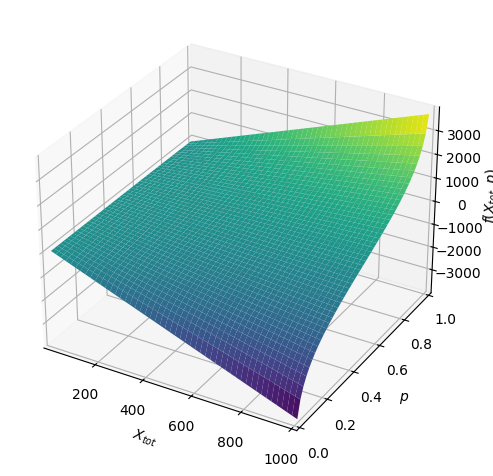

In [9]:
plot3d(log_l.subs(n, 10), (X_tot, 1,1000), (p, 0,1))

In [23]:
# Take partial derivative

foc = Eq(diff(log_l, p), 0)

solve(foc, p)[0]

X_tot/n

## Implementing the MLE in `statsmodels`

- We know that $\hat{p}$ is really just the mean of the data, which we can solve for analytically
    - Always try to do this first, because numerical solutions become unwieldy and untrustworthy as the complexity of the model grows.
- But for more complicated models, this may not be the case, and we need to solve for it numerically
- In this case, we can inherit from `statsmodels` MLE class and just change what we need, getting all the toher nice stuff that we usually can from `statsmodels`.
- And unless we need it, we can just change one method in that class, `loglike`, the log-likelihood function, or `nloglikeobs`, the log likelihood for one observation
    - If your likelihood function can be broken down by observation (which it sometimes can but sometimes can't) then you should use as there are more options from the class available and are dependent on the one-observations log-likelihood
- let's do this with a normal distribution.
- The log-likelihood of a normal distribution will be:

$$
\log L(\beta) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log (\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^n (y_i - X\beta)^2
$$

In [82]:
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
import numpy as np
from scipy.stats import norm
from statsmodels.sandbox.regression.gmm import GMM


In [77]:
class NormalMLE(GenericLikelihoodModel):
    
    def __init__(self, endog, exog, **kwds):
        super().__init__(endog,exog, **kwds)
        self.nobs = self.exog.shape[0]
    
    def loglike(self, params):
        beta = params
        n = self.nobs
        sigma=self.endog.std()
        
        log_like = -(n/2)*np.log(2*np.pi) - (n/2)*np.log(sigma**2) - (1/(2*sigma**2))*np.sum((self.endog - (self.exog @ beta))**2)
        return log_like
        

In [78]:
X = np.random.normal(size=(1000,10))
y = X @ [1,2,3,4,5,6,7,8,9,10] + np.random.normal(size=1000)

mod = NormalMLE(y,X)

mod.fit(maxiter=10000).summary()

Optimization terminated successfully.
         Current function value: 3.925705
         Iterations: 2252
         Function evaluations: 3172


/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")


<class 'statsmodels.iolib.summary.Summary'>
"""
                              NormalMLE Results                               
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -3925.7
Model:                      NormalMLE   AIC:                             7869.
Method:            Maximum Likelihood   BIC:                             7914.
Date:                Mon, 13 Nov 2023                                         
Time:                        15:03:03                                         
No. Observations:                1000                                         
Df Residuals:                     990                                         
Df Model:                           9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2226      0.623      1.963      0.050       0.002       2.443
x2             2.0668      0.660      3.131      0.002       0.773       3.361
x3             2.8222      0.645      4.376      0.000       1.558       4.086
x4             3.9368      0.633      6.220      0.000       2.696       5.177
x5             4.3175      0.634      6.805      0.000       3.074       5.561
x6             6.1211      0.642      9.527      0.000       4.862       7.380
x7             6.0818      0.625      9.735      0.000       4.857       7.306
x8             8.5226      0.644     13.238      0.000       7.261       9.784
x9             8.9051      0.655     13.592      0.000       7.621      10.189
x10           10.4572      0.620     16.853      0.000       9.241      11.673
==============================================================================
"""

In [74]:
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          4.391e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:02:27   Log-Likelihood:                         -1389.9
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     990   BIC:                                      2849.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0388      0.031     33.754      0.000       0.978       1.099
x2             1.9522      0.032     60.463      0.000       1.889       2.016
x3             2.9145      0.032     90.704      0.000       2.851       2.978
x4             3.9984      0.030    131.642      0.000       3.939       4.058
x5             4.9557      0.032    155.422      0.000       4.893       5.018
x6             5.9814      0.031    195.255      0.000       5.921       6.042
x7             7.0176      0.030    231.174      0.000       6.958       7.077
x8             8.0175      0.030    265.968      0.000       7.958       8.077
x9             9.0325      0.030    302.362      0.000       8.974       9.091
x10           10.0757      0.030    330.519      0.000      10.016      10.136
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                1.443
Skew:                          -0.046   Prob(JB):                        0.486
Kurtosis:                       2.838   Cond. No.                         1.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""